In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
data=pd.read_csv("Company Stock and Investment.csv")
data.head()

,Date,Oil Investments,Gold Investments,Comp Stock,Other sharesInvestments
0,31-12-2009,0.025417,0.000150,0.017354,0.006848
1,04-01-2010,0.026830,0.001097,0.015565,-0.004609
2,05-01-2010,0.002699,0.001560,0.001729,0.005900
3,06-01-2010,0.021688,0.006009,-0.015906,-0.018116
4,07-01-2010,-0.006256,0.000221,-0.001849,-0.017013


In [3]:
data['Date'].min()

'01-02-2010'

In [4]:
data['Date'].max()

'31-12-2015'

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 5 columns):
Date                       1984 non-null object
Oil Investments            1984 non-null float64
Gold Investments           1984 non-null float64
Comp Stock                 1984 non-null float64
Other sharesInvestments    1984 non-null float64
dtypes: float64(4), object(1)
memory usage: 77.6+ KB


In [6]:
data['Date']=pd.to_datetime(data['Date'],format='%d-%m-%Y')

# Oil Investments


In [7]:
#Lets consider the Gold Investments as our target and drop all others columns.

df=data.drop(columns=["Gold Investments","Comp Stock","Other sharesInvestments"],axis=1)
df.head()

,Date,Oil Investments
0,2009-12-31,0.025417
1,2010-01-04,0.026830
2,2010-01-05,0.002699
3,2010-01-06,0.021688
4,2010-01-07,-0.006256


In [8]:
# making date as my index column

df.set_index('Date',inplace=True)
df.head()

,Oil Investments
Date,
2009-12-31,0.025417
2010-01-04,0.026830
2010-01-05,0.002699
2010-01-06,0.021688
2010-01-07,-0.006256


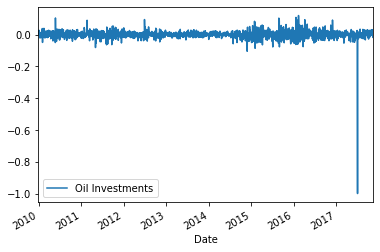

In [9]:
df.plot()

In [10]:
df.describe()

,Oil Investments
count,1984.000000
mean,-0.000435
std,0.030869
min,-1.000000
25%,-0.011021
50%,0.000277
75%,0.010734
max,0.119511


In [11]:
#check if data is stationarity or not

def adfuller_test(target):
    result=adfuller(target)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary")
    else:
        print("weak evidence against null hypothesis, time series is non-stationary ")

In [12]:
adfuller_test(df['Oil Investments'])

ADF Test Statistic : -45.94216292983992
p-value : 0.0
#Lags Used : 0
Number of Observations Used : 1983
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data  is stationary


In [13]:
# average the daily stock value of gold investment for each month

y = df['Oil Investments'].resample('MS').mean()
y['2009':]

Date
2009-12-01    0.025417
2010-01-01   -0.003889
2010-02-01    0.005004
2010-03-01    0.002077
2010-04-01    0.001572
                ...   
2017-07-01   -0.044539
2017-08-01   -0.002489
2017-09-01    0.004568
2017-10-01    0.002403
2017-11-01    0.001612
Freq: MS, Name: Oil Investments, Length: 96, dtype: float64

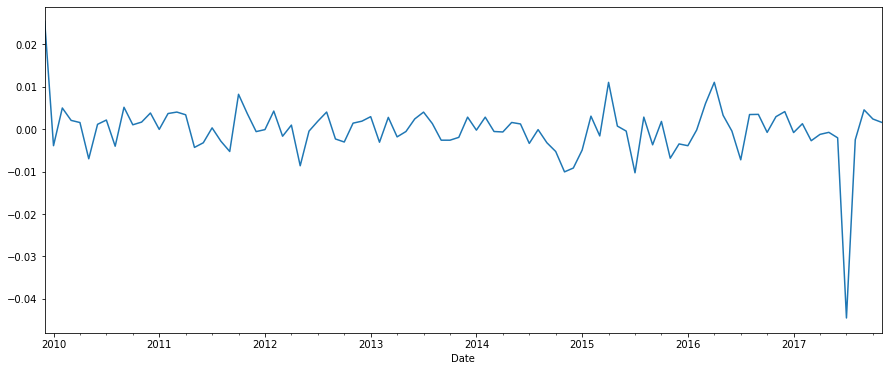

In [14]:
y.plot(figsize = (15, 6))

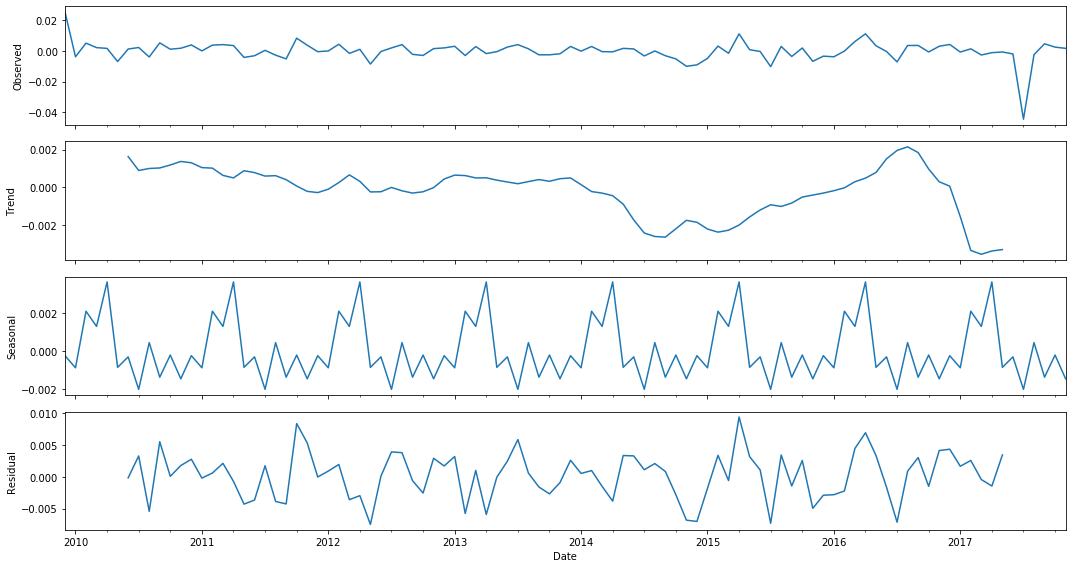

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

Visualizing our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

# Time series forecasting with ARIMA
Applying one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data.

In [16]:
# set the typical ranges for p, d, q
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
# Using Grid Search find the optimal set of parameters that yields the best performance
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal, enforce_stationary = False,enforce_invertibility=False) 
            result = mod.fit()   
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, result.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:-690.7010385107903
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:-694.9512476802697
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-599.8084292817435
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-600.2680602113655
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-697.3337493860183
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-695.4661230436404
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-599.7534426548797
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-596.5273973253825
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:-689.4210774010605
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-693.2986900096009
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-598.6982484872236
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-599.7680246827814
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-695.8689880216989
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-693.0950591082619
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-599.2153810458091
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-595.2099915032853
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-633.1612615817951
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-636.746486

The above output suggests that SARIMAX(0, 0, 0)x(1, 0, 0, 12) yields the lowest AIC value of -697.333. Therefore we should consider this to be optimal option.

In [18]:
model = sm.tsa.statespace.SARIMAX(y, order = (0, 0, 0),seasonal_order = (1, 0, 0, 12))
result = model.fit()
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3874      0.144      2.686      0.007       0.105       0.670
sigma2      3.854e-05   2.72e-06     14.145      0.000    3.32e-05    4.39e-05


In [19]:
prediction = result.get_prediction(start = pd.to_datetime('2016-07-01'), dynamic = False)
prediction_ci = prediction.conf_int()
prediction_ci

,lower Oil Investments,upper Oil Investments
Date,,
2016-07-01,-0.016151,0.008183
2016-08-01,-0.011063,0.013271
2016-09-01,-0.013594,0.010740
2016-10-01,-0.011458,0.012876
2016-11-01,-0.014821,0.009513
2016-12-01,-0.013513,0.010821
2017-01-01,-0.013676,0.010659
2017-02-01,-0.012239,0.012095
2017-03-01,-0.009822,0.014512


# Validating forecasts
To help us understand the accuracy of our forecasts, we compare predicted stock value to real stock value of the time series, and we set forecasts to start at 2016–07–01 to the end of the data

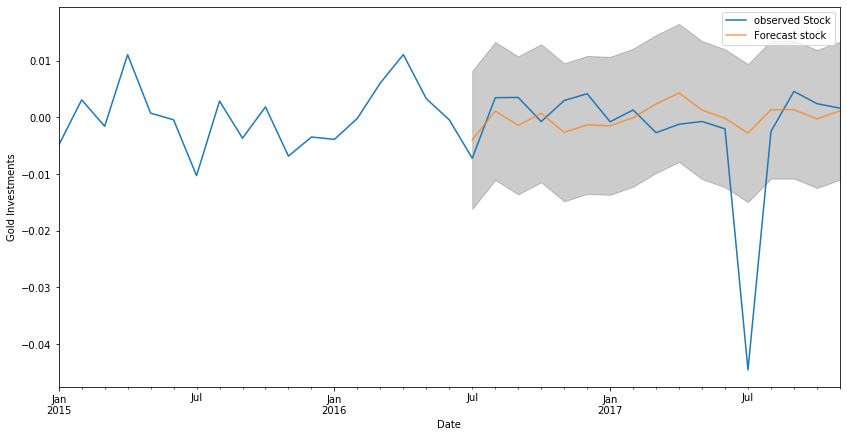

In [20]:
pred = result.get_prediction(start=pd.to_datetime('2016-07-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed Stock')
pred.predicted_mean.plot(ax=ax, label='Forecast stock', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Gold Investments')
plt.legend()
plt.show()


In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-07-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.0


In [22]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.01


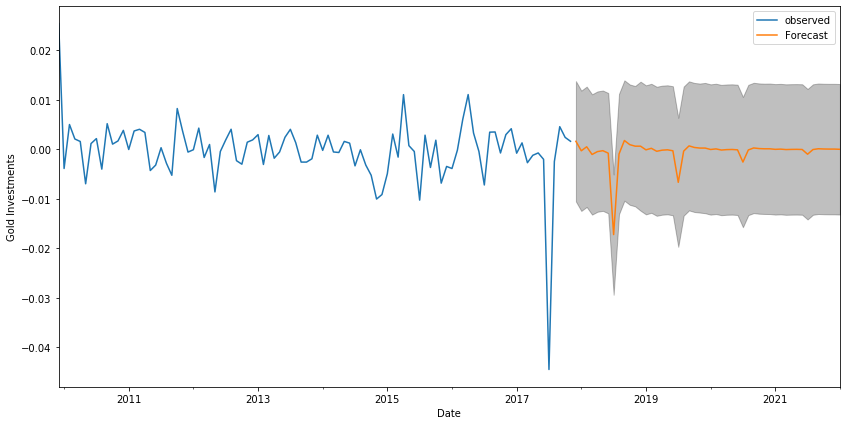

In [23]:
pred_uc = result.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Gold Investments')
plt.legend()
plt.show()